# Microsoft: DAT102x Microsoft Professional Capstone : Data Science

# Makes Predictions based on Two Data Inputs and One Test Output
(train_labels.csv, train_values_6tLXv3T.csv, test_values_K7FqC54.csv)

By: Muhamad Amirul Rasyid Bin Sa'don

In [1]:
!pip install xgboost

    100% |████████████████████████████████| 16.6MB 73kB/s eta 0:00:011   51% |████████████████▌               | 8.6MB 6.0MB/s eta 0:00:02    58% |██████████████████▉             | 9.8MB 4.6MB/s eta 0:00:02    90% |████████████████████████████▉   | 15.0MB 3.0MB/s eta 0:00:01


In [2]:
!pip install fancyimpute

    100% |████████████████████████████████| 921kB 3.4MB/s eta 0:00:01    85% |███████████████████████████▎    | 778kB 9.0MB/s eta 0:00:01
    100% |████████████████████████████████| 61kB 3.3MB/s ta 0:00:011
    100% |████████████████████████████████| 153kB 5.9MB/s eta 0:00:01
    100% |████████████████████████████████| 153kB 5.9MB/s eta 0:00:01
    100% |████████████████████████████████| 143kB 5.0MB/s ta 0:00:01
    100% |████████████████████████████████| 1.4MB 4.8MB/s ta 0:00:011
    100% |████████████████████████████████| 51kB 1.8MB/s ta 0:00:01
  Running setup.py bdist_wheel for fancyimpute ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/4c/dc/65/3b721b985a3810d645829367fa42007e97db12573e6bb27f9f
  Running setup.py bdist_wheel for knnimpute ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/a3/92/31/c3f8864714e9938396c3a68d8c542531f7e2d7862bb750b2e3
  Running setup.py bdist_wheel for cvxpy ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/7e/6

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from fancyimpute import KNN
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
train_y = pd.read_csv('datasets/train_labels.csv')
train_x = pd.read_csv('datasets/train_values_6tLXv3T.csv')
test = pd.read_csv('datasets/test_values_K7FqC54.csv')
print(train_x.shape,train_y.shape,test.shape)
# train_x.columns
print(train_y.prevalence_of_undernourishment.describe())

(1401, 46) (1401, 2) (616, 46)
count    1401.000000
mean       15.510697
std        11.610440
min         2.493428
25%         5.710856
50%        12.118656
75%        22.447492
max        59.089781
Name: prevalence_of_undernourishment, dtype: float64


In [8]:
#To Answer Data Exploration Questions
# df =train_x
# df['target'] = train_y.prevalence_of_undernourishment
# x = df.groupby('year')
# x.median().target
# x.mean().target

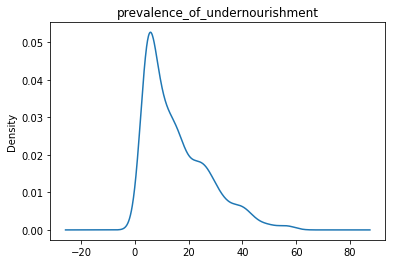

In [21]:
#target distribution
 train_y.prevalence_of_undernourishment.plot(kind='density',title='prevalence_of_undernourishment')

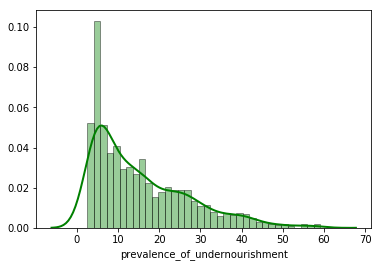

In [22]:
# Density Plot and Histogram of all arrival delays
sns.distplot(train_y.prevalence_of_undernourishment, hist=True, kde=True, 
             bins=int(180/5), color = 'green', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

In [10]:
#print correlation between y and columns
imp_num=[]
imp=[]
for i in train_x.columns[3:-1]:
    tmp = train_y.prevalence_of_undernourishment.corr(train_x[i])
    print(i,':',tmp)
    imp += [abs(tmp)]
    if abs(tmp)>0.5:
        imp_num += [i]
#         print(i,':',tmp)
# plt.plot(df_num.columns,imp)
print(imp_num)

agricultural_land_area : 0.006627019407177684
percentage_of_arable_land_equipped_for_irrigation : -0.13804832873565065
cereal_yield : -0.24946974949317405
droughts_floods_extreme_temps : 0.23699225101399282
forest_area : -0.003169208649612546
total_land_area : -0.0024533934280382744
fertility_rate : 0.49710752762865207
life_expectancy : -0.47626368824248777
rural_population : 0.054463319809451495
total_population : 0.025694981997350843
urban_population : -0.033759231493159896
population_growth : 0.25520489827104076
avg_value_of_food_production : -0.38971999758215187
cereal_import_dependency_ratio : 0.046330424776001945
food_imports_as_share_of_merch_exports : 0.18175593862572684
gross_domestic_product_per_capita_ppp : -0.33551291971331754
imports_of_goods_and_services : -0.0015793586431821734
inequality_index : 0.1847990792517113
net_oda_received_percent_gni : 0.37788788969120995
net_oda_received_per_capita : 0.02153071941828668
tax_revenue_share_gdp : -0.1810890540098128
trade_in_serv

Catogory: Index(['country_code', 'year'], dtype='object')


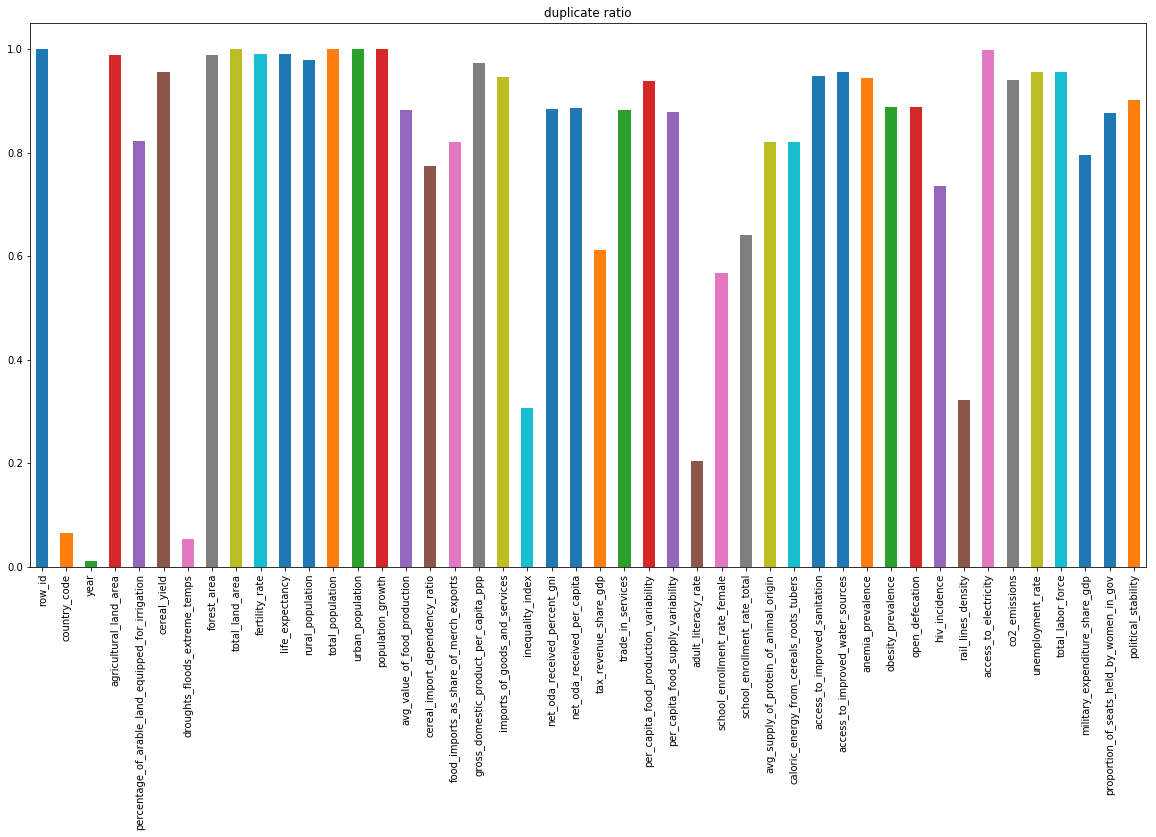

In [11]:
# duplicate ratio
plt.figure(figsize=(20,10))
(train_x.apply(lambda x:x.unique().shape[0],axis=0)/train_x.shape[0]).plot(kind='bar',title='duplicate ratio')
print('Catogory:',train_x.columns[1:3])
#check whether id has duplicate rows
assert len(train_x.row_id.unique())-train_x.shape[0]==0

na.ratio>0.4 :
droughts_floods_extreme_temps    0.946467
inequality_index                 0.693790
adult_literacy_rate              0.796574
school_enrollment_rate_female    0.432548
rail_lines_density               0.673804
dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


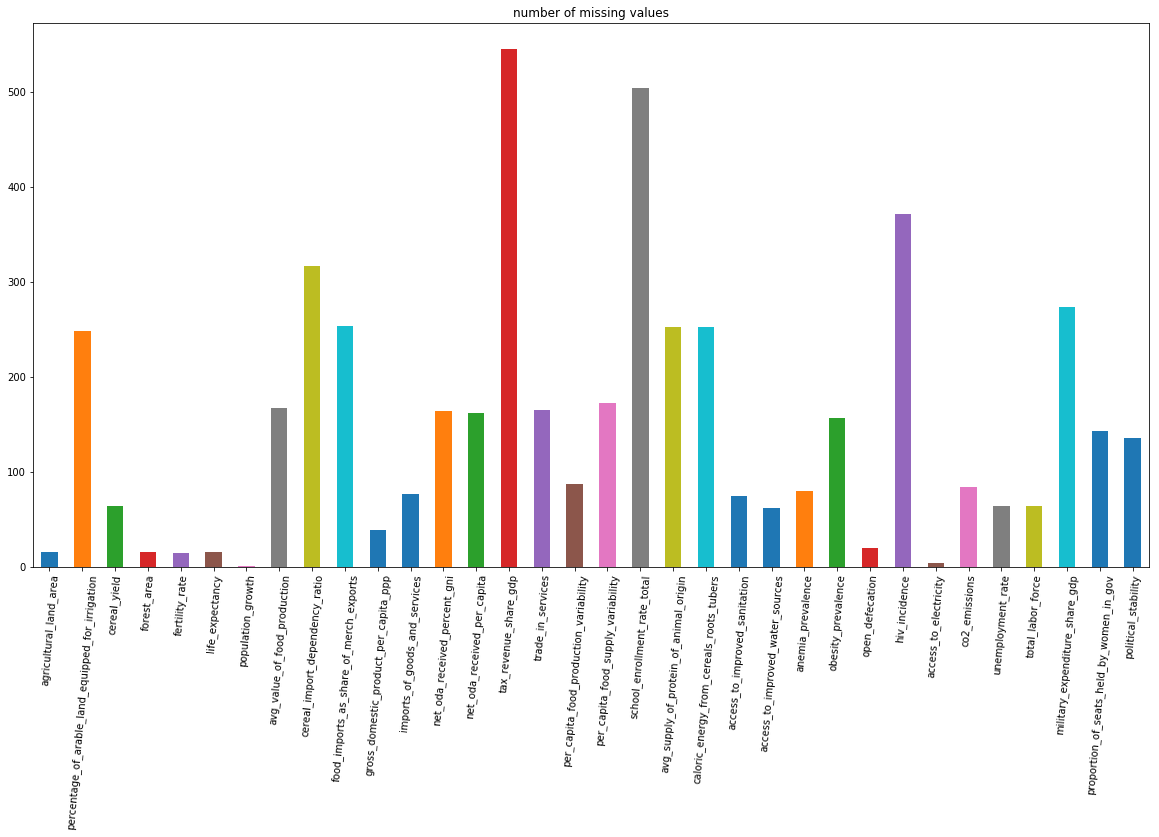

In [12]:
#remove na.ratio>0.4 columns
na_ratio = train_x.isna().sum()/train_x.shape[0]
tmp = na_ratio[na_ratio>0.4]
print('na.ratio>0.4 :',tmp,sep='\n')
droped_columns=tmp.index
train_x = train_x.drop(columns=droped_columns)
tmp = train_x.isna().sum()/train_x.shape[0]
tmpp = tmp[tmp>0]
plt.figure(figsize=(20,10))
print(train_x[tmpp.index].isnull().sum().plot(kind='bar',rot=85,title='number of missing values'))

AxesSubplot(0.125,0.125;0.775x0.755)


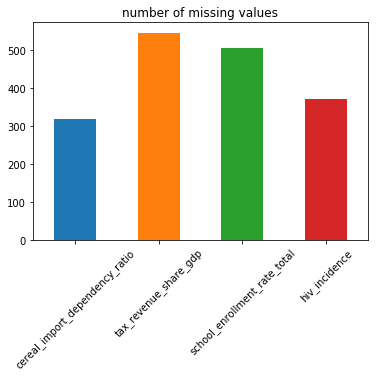

In [13]:
#rest high na_ratio columns
tmpp = tmp[tmp>0.2]
print(train_x[tmpp.index].isnull().sum().plot(kind='bar',rot=45,title='number of missing values'))

In [14]:
#fillna with KNN
train_x2 = KNN(k=5).fit_transform(train_x.iloc[:,3:])
train_x_df = pd.DataFrame(data=train_x2,index=range(1401),columns=train_x.columns[3:])
train_x_df['year'] = train_x.year
train_x = train_x_df
assert train_x.shape[1]==39
assert train_x.isna().any().sum()==0

Imputing row 1/1401 with 3 missing, elapsed time: 3.067
Imputing row 101/1401 with 0 missing, elapsed time: 3.110
Imputing row 201/1401 with 5 missing, elapsed time: 3.151
Imputing row 301/1401 with 0 missing, elapsed time: 3.210
Imputing row 401/1401 with 0 missing, elapsed time: 3.248
Imputing row 501/1401 with 1 missing, elapsed time: 3.322
Imputing row 601/1401 with 1 missing, elapsed time: 3.371
Imputing row 701/1401 with 2 missing, elapsed time: 3.449
Imputing row 801/1401 with 0 missing, elapsed time: 3.514
Imputing row 901/1401 with 1 missing, elapsed time: 3.573
Imputing row 1001/1401 with 4 missing, elapsed time: 3.613
Imputing row 1101/1401 with 2 missing, elapsed time: 3.656
Imputing row 1201/1401 with 2 missing, elapsed time: 3.695
Imputing row 1301/1401 with 18 missing, elapsed time: 3.729
Imputing row 1401/1401 with 0 missing, elapsed time: 3.767


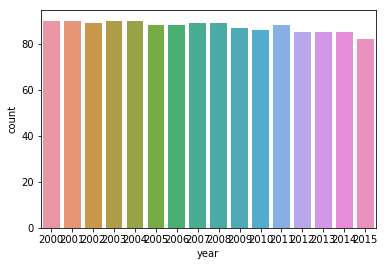

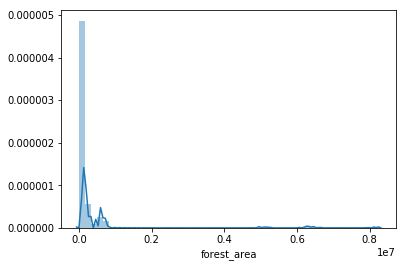

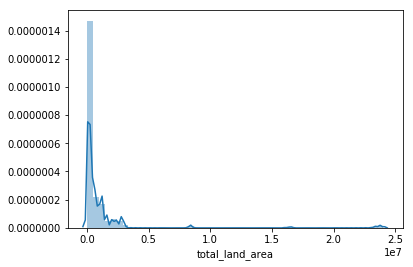

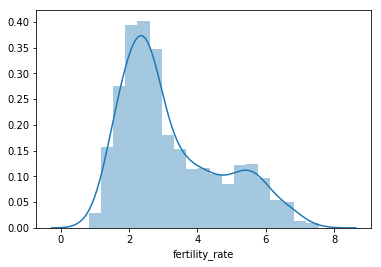

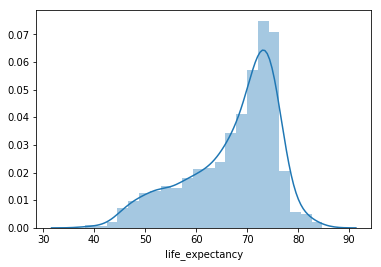

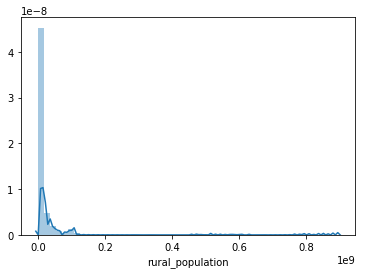

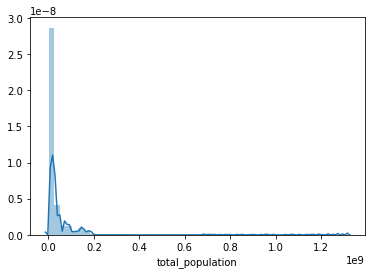

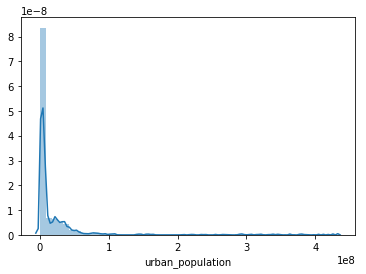

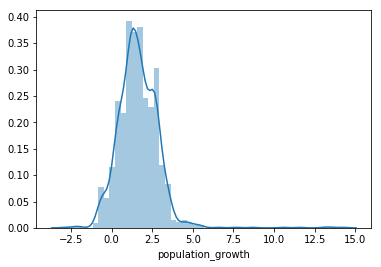

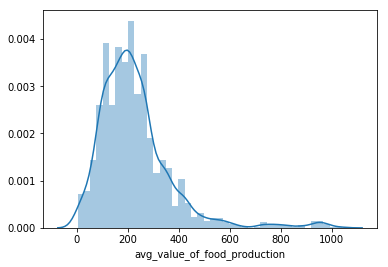

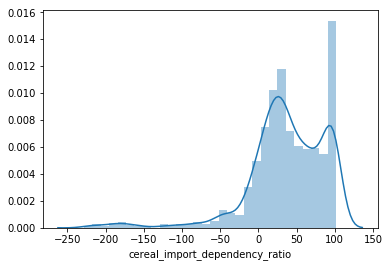

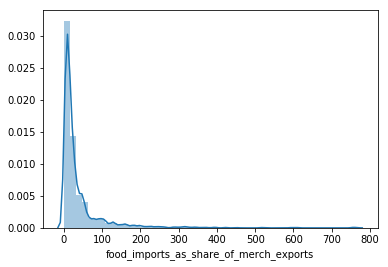

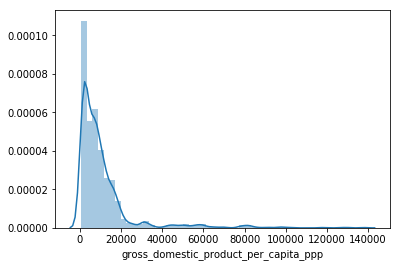

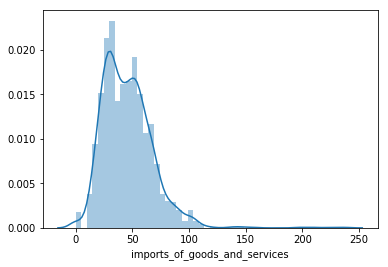

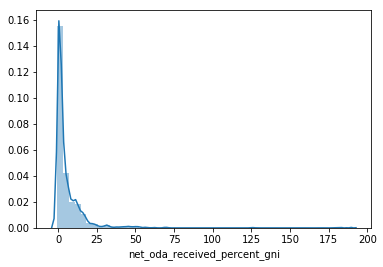

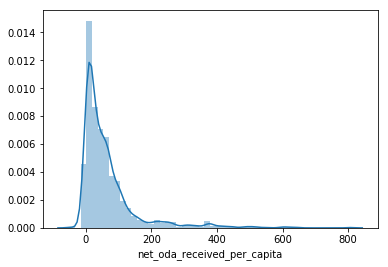

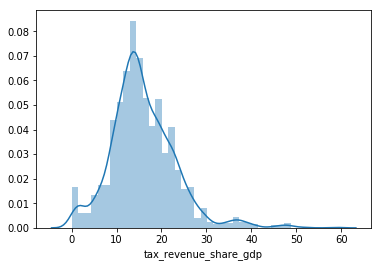

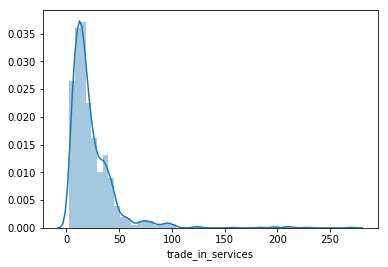

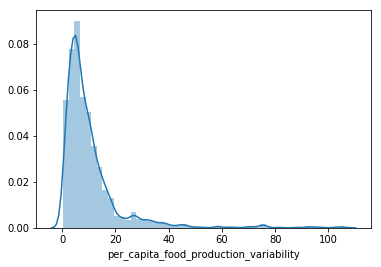

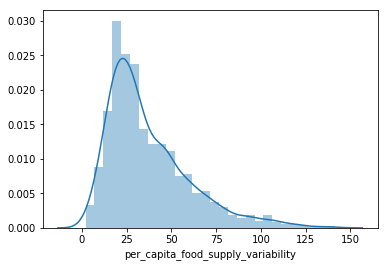

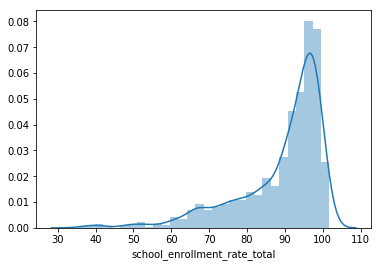

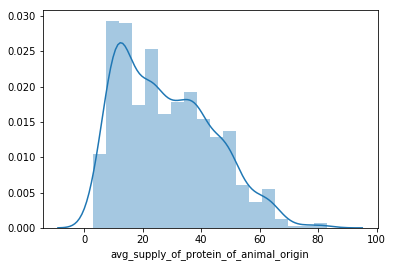

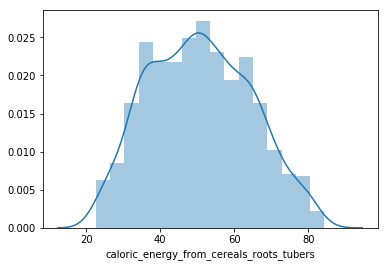

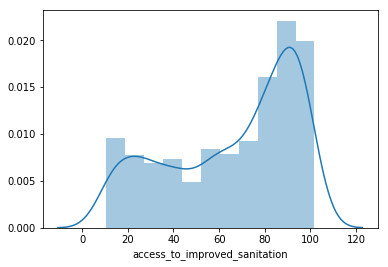

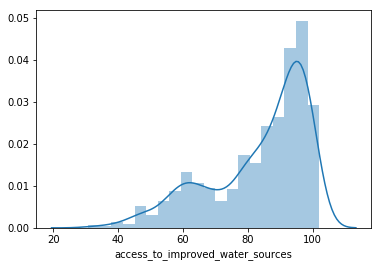

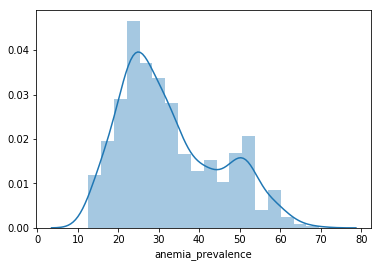

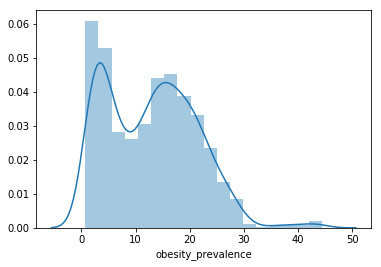

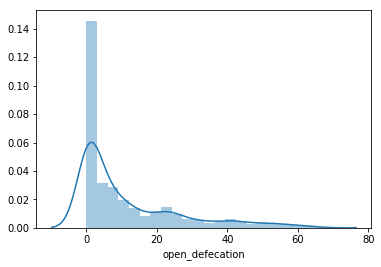

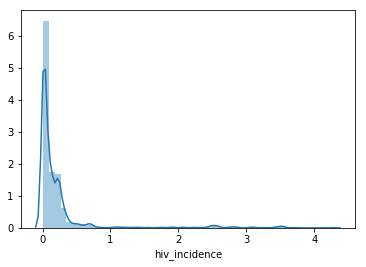

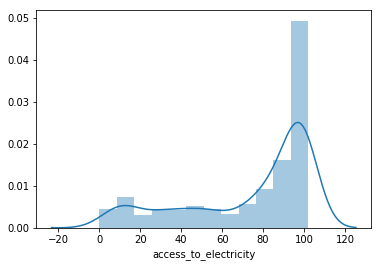

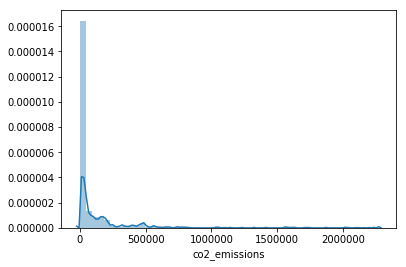

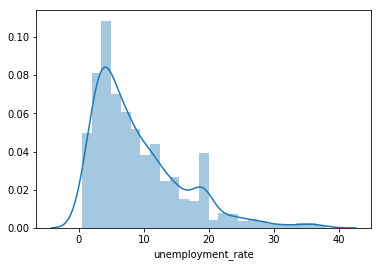

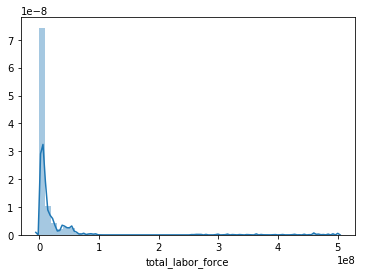

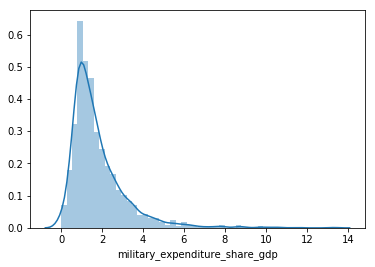

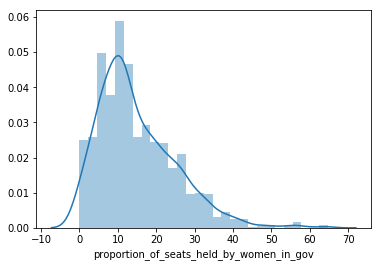

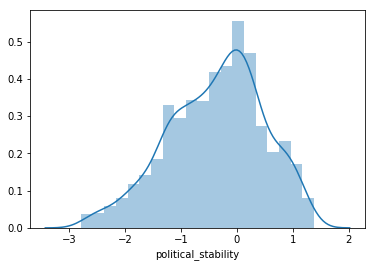

In [15]:
#print columns distribution
sns.countplot(x='year', data=train_x)
plt.show()
for i in train_x.columns[3:-1]:
    sns.distplot(train_x[i])
    plt.show()

In [16]:
#replace outliers
for col in train_x.columns[3:-1]:
    scaler = StandardScaler()
    scaler.fit(train_x[[col]])
    ss = scaler.transform(train_x[[col]])
    maxv = ss.mean()+3*ss.std()
    minv = ss.mean()-3*ss.std()
    for i in range(len(ss)):
        if ss[i]<minv:
            ss[i] = minv
        if ss[i]>maxv:
            ss[i] = maxv
    train_x[col] = scaler.inverse_transform(ss)

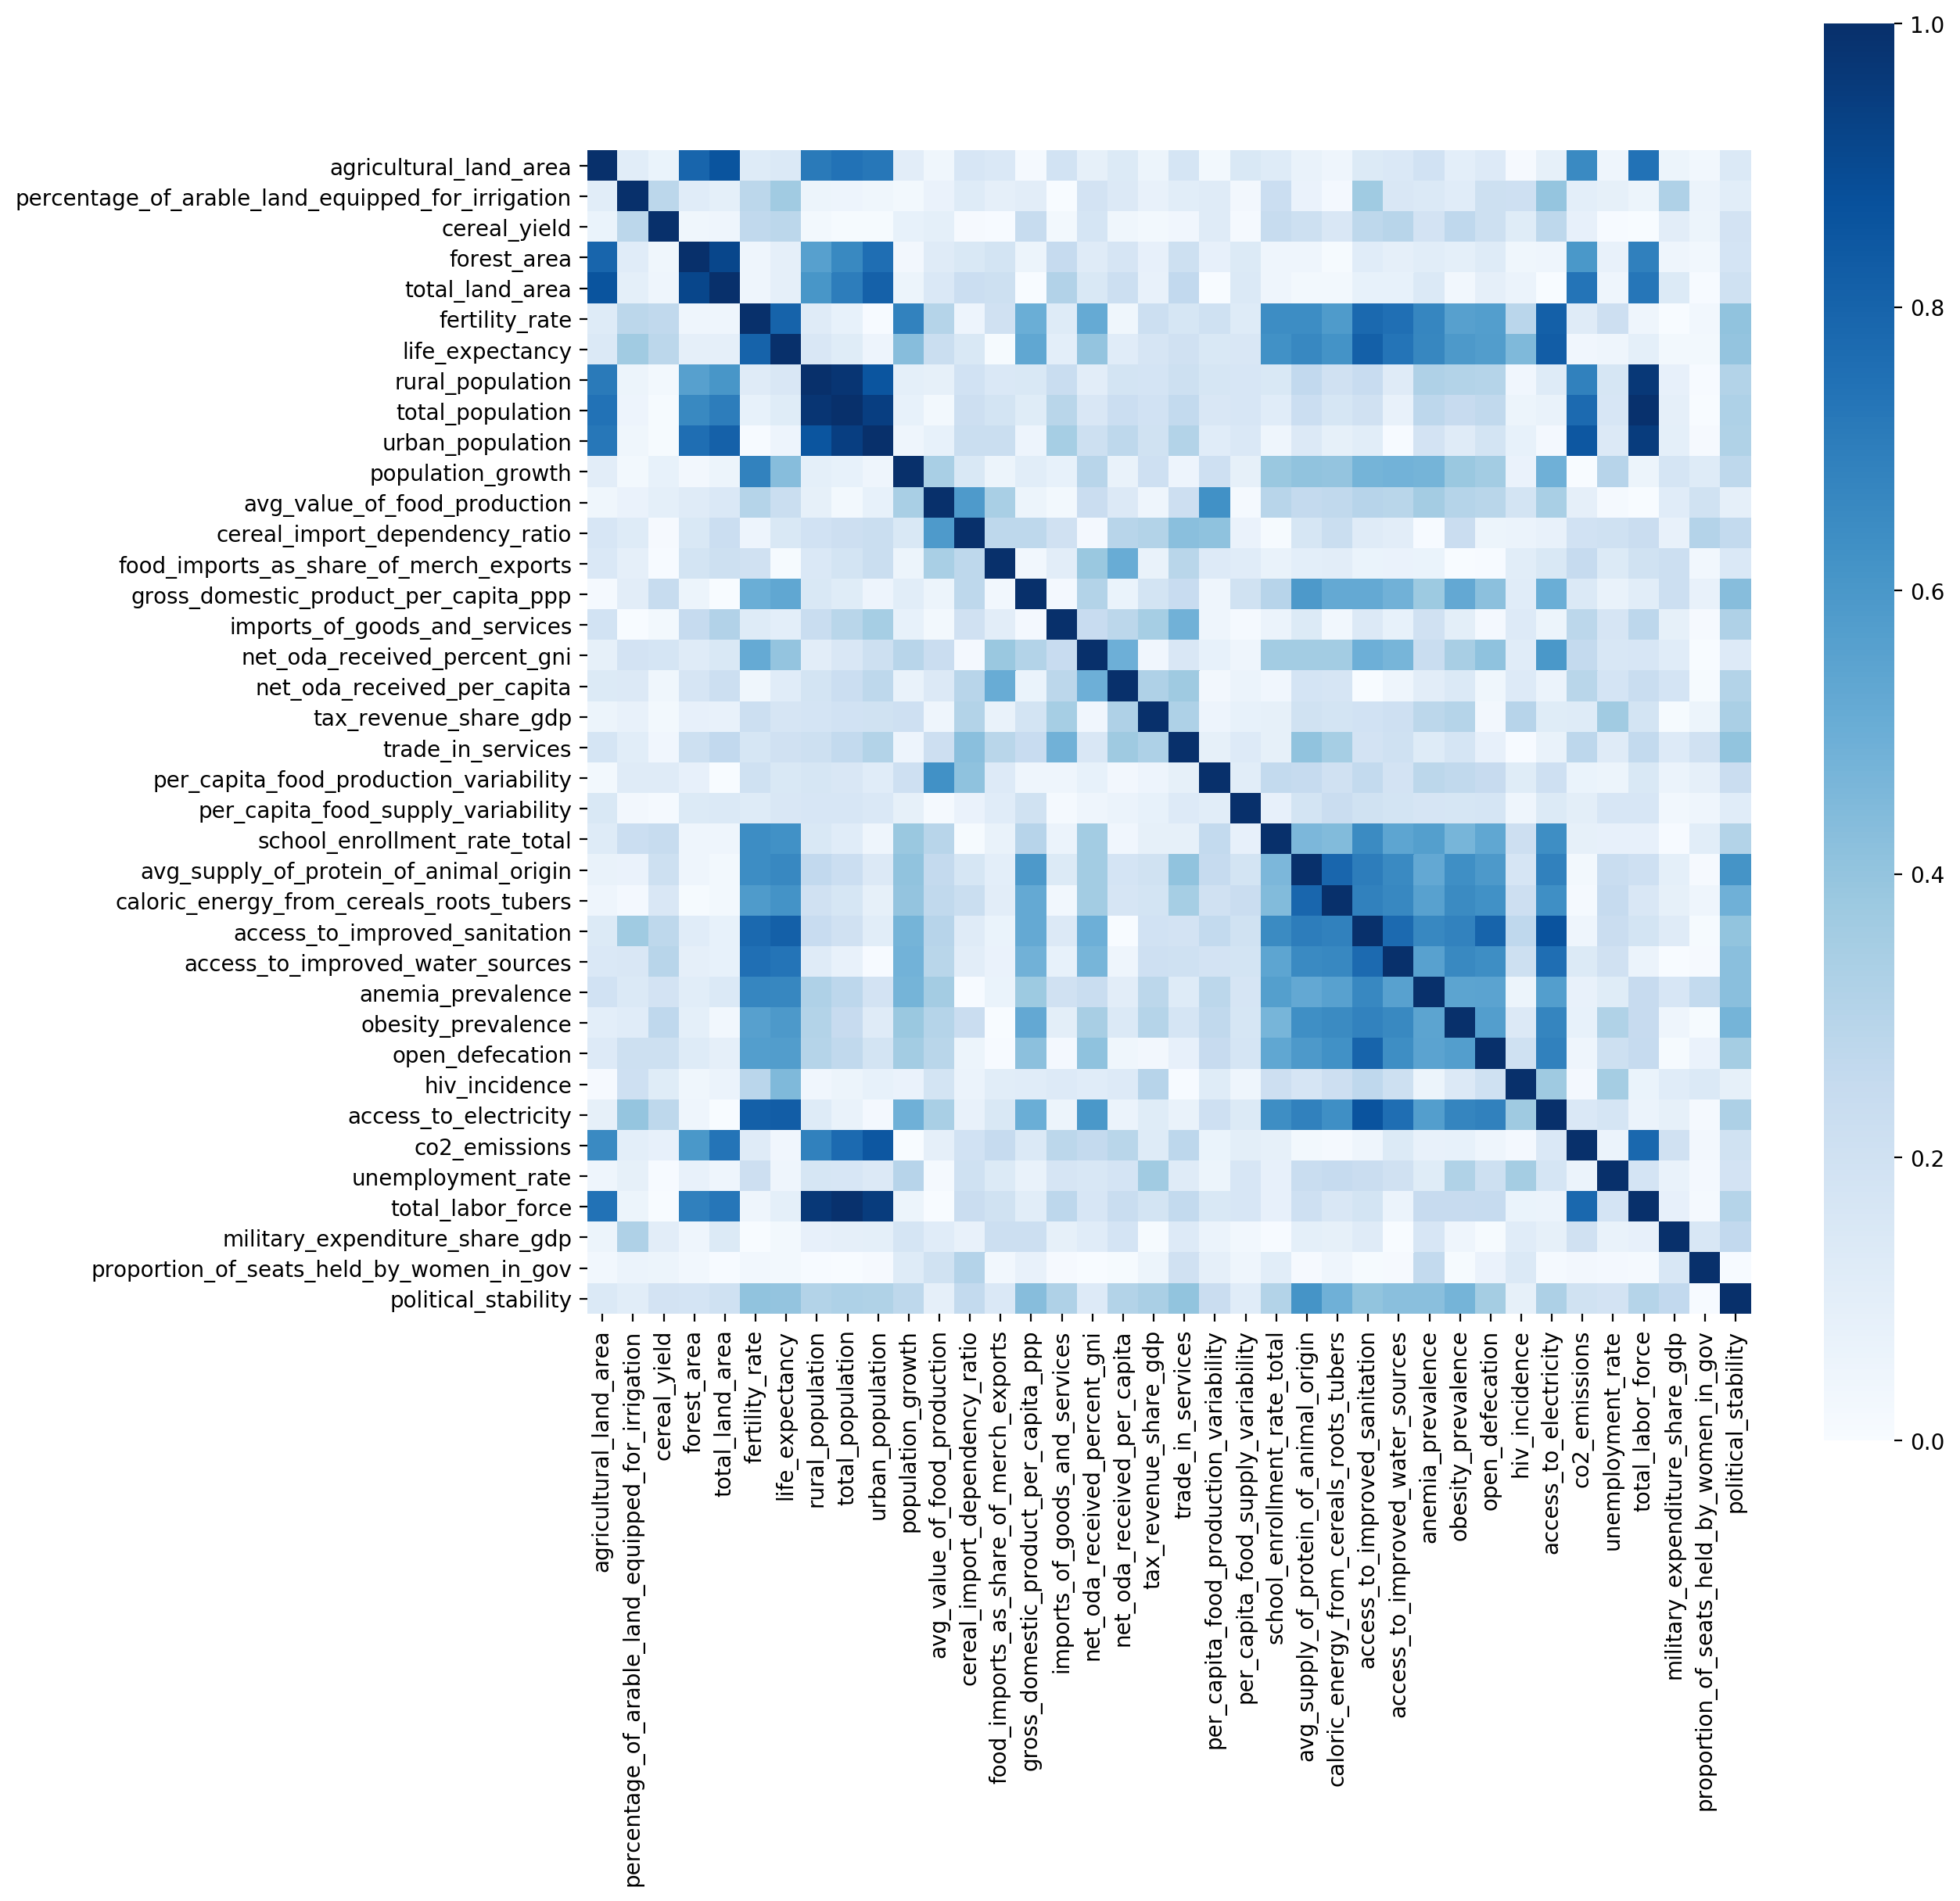

In [17]:
#print correlation table
plt.figure(figsize=(12,12),dpi=200)
sns.heatmap( abs(train_x.drop(columns=['year']).corr()),cmap="Blues",
             vmin=0,
             vmax=1,
             square=True,
             annot=False)
plt.show()

In [18]:
#list high correlation column pairs
tmp = abs(train_x.drop(columns=['year']).corr())
tmpp = tmp[tmp!=1]
pair=[]
prePCA=[]
for i in range(tmpp.shape[0]):
    for j in range(tmpp.shape[0]):
        if tmpp.iloc[i,j]>0.7:
            pair += [tmpp.columns[i]+tmpp.columns[j]]
            if tmpp.columns[j]+tmpp.columns[i] not in pair:
                print(tmpp.columns[i],'--------',tmpp.columns[j])
                prePCA+=[(tmpp.columns[i],tmpp.columns[j])]

agricultural_land_area -------- forest_area
agricultural_land_area -------- total_land_area
agricultural_land_area -------- rural_population
agricultural_land_area -------- total_population
agricultural_land_area -------- urban_population
agricultural_land_area -------- total_labor_force
forest_area -------- total_land_area
forest_area -------- urban_population
total_land_area -------- total_population
total_land_area -------- urban_population
total_land_area -------- co2_emissions
total_land_area -------- total_labor_force
fertility_rate -------- life_expectancy
fertility_rate -------- access_to_improved_sanitation
fertility_rate -------- access_to_improved_water_sources
fertility_rate -------- access_to_electricity
life_expectancy -------- access_to_improved_sanitation
life_expectancy -------- access_to_improved_water_sources
life_expectancy -------- access_to_electricity
rural_population -------- total_population
rural_population -------- urban_population
rural_population -------- t

In [19]:
#list columns might have Multi-Collinearity problem
flattened_list = set([y for x in prePCA for y in x])
print(flattened_list)

{'access_to_electricity', 'total_labor_force', 'access_to_improved_sanitation', 'co2_emissions', 'urban_population', 'agricultural_land_area', 'rural_population', 'total_population', 'avg_supply_of_protein_of_animal_origin', 'access_to_improved_water_sources', 'open_defecation', 'life_expectancy', 'forest_area', 'fertility_rate', 'total_land_area', 'caloric_energy_from_cereals_roots_tubers'}


In [20]:
#try to fix Multi-Collinearity problem

train_x['rural_population'] = train_x.rural_population/train_x.total_population
train_x['urban_population'] = train_x.urban_population/train_x.total_population
train_x['agricultural_land_area'] = train_x.agricultural_land_area/train_x.total_land_area
train_x['forest_area'] = train_x.forest_area/train_x.total_land_area
train_x.rename(columns={'rural_population':'rural_population_ratio',
               'urban_population':'urban_population_ratio',
               'agricultural_land_area':'agricultural_land_area_ratio',
               'forest_area':'forest_area_ratio'},inplace=True)

def Polymerization(cols,new_name,data):
    pca = PCA(n_components=1)
    new_col = pca.fit_transform(data[cols])
    data.drop(columns=cols,inplace=True)
    data[new_name]=new_col
    return data

health_food = ['avg_supply_of_protein_of_animal_origin','caloric_energy_from_cereals_roots_tubers']
health_facility = ['life_expectancy','access_to_improved_sanitation','access_to_improved_water_sources','access_to_electricity','fertility_rate']
Polymerization(health_food,'health_food',train_x)
Polymerization(health_facility,'health_facility',train_x)
print(train_x.shape)

(1401, 34)


In [21]:
#one-hot encoding catogory column
train_x = pd.get_dummies(data=train_x,columns=['year'])
print(train_x.shape)

(1401, 49)


In [22]:
def prepare_test(test):
    test.drop_duplicates(subset=['row_id'],inplace=True)
    test.drop(columns=['row_id','country_code'],inplace=True)
    test.drop(columns=droped_columns,inplace=True)
    knn = KNN(k=5).fit_transform(test.drop(columns=['year']))
    test2 = pd.DataFrame(data=knn,index=range(test.shape[0]),columns=test.drop(columns=['year']).columns)    
    test2['year'] = test.year
    assert test2.shape[1]==39
    assert test2.isna().any().sum()==0
    test2['rural_population'] = test2.rural_population/test2.total_population
    test2['urban_population'] = test2.urban_population/test2.total_population
    test2['agricultural_land_area'] = test2.agricultural_land_area/test2.total_land_area
    test2['forest_area'] = test2.forest_area/test2.total_land_area
    test2.rename(columns={'rural_population':'rural_population_ratio',
               'urban_population':'urban_population_ratio',
               'agricultural_land_area':'agricultural_land_area_ratio',
               'forest_area':'forest_area_ratio'},inplace=True)
    assert test2.isna().any().sum()==0
    Polymerization(health_food,'health_food',test2)
    Polymerization(health_facility,'health_facility',test2)
    test2 = pd.get_dummies(data=test2,columns=['year'])
    return test2
test = prepare_test(test)

Imputing row 1/616 with 3 missing, elapsed time: 0.652
Imputing row 101/616 with 1 missing, elapsed time: 0.680
Imputing row 201/616 with 0 missing, elapsed time: 0.710
Imputing row 301/616 with 1 missing, elapsed time: 0.739
Imputing row 401/616 with 12 missing, elapsed time: 0.770
Imputing row 501/616 with 1 missing, elapsed time: 0.802
Imputing row 601/616 with 10 missing, elapsed time: 0.820


In [23]:
#Save cleaned datasets
# train_x.to_csv('D:/cleaned_train_x.csv',index=False)
# train_y.iloc[:,1].to_csv('D:/cleaned_train_y.csv',index=False)

In [28]:
train_x.shape,test.shape

((1401, 49), (616, 49))

In [29]:
#Standardlization
train_x_org = train_x.copy()
scaler = StandardScaler()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
test = scaler.transform(test)
train_x.shape,train_y.shape,test.shape

((1401, 49), (1401, 2), (616, 49))

In [30]:
train_x.shape,train_y.prevalence_of_undernourishment.shape,test.shape

((1401, 49), (1401,), (616, 49))

In [33]:
#feature selection
lcv = LassoCV(cv=10,alphas=[i/10000 for i in range(1000,15000,5)])
lcv.fit(train_x, train_y.iloc[:,1])
df_features = pd.DataFrame()
df_features['feature']=train_x_org.columns
df_features['coef']=lcv.coef_
df = df_features[abs(df_features.coef)>0]
print(df.shape)
df.sort_values('coef')

(37, 2)


,feature,coef
21,anemia_prevalence,-2.717874
22,obesity_prevalence,-2.576662
9,avg_value_of_food_production,-2.046897
30,political_stability,-1.868730
24,hiv_incidence,-1.352519
6,total_population,-1.041570
16,tax_revenue_share_gdp,-0.819035
13,imports_of_goods_and_services,-0.532720
25,co2_emissions,-0.411878
2,cereal_yield,-0.371198


In [47]:
#feature selection
lcv = LassoCV(cv=10,alphas=[i/10000 for i in range(10000,15000,5)])
sfm = SelectFromModel(lcv, threshold=0.25)
sfm.fit(train_x, train_y.iloc[:,1])
tmp = sfm.transform(train_x)
tmp2 = sfm.transform(test)
tmp.shape,tmp2.shape
# assert tmp.shape[1]==tmp2.transform(train_x).shape[1]

((1401, 7), (616, 7))

In [48]:
#Fitting RandomForest regressor
regr = RandomForestRegressor(n_estimators=271,oob_score=True,n_jobs=-1)
regr.fit(train_x, train_y.iloc[:,1])
pred_y = regr.predict(test)
print(pred_y)

[ 4.95621569  6.31394189 11.46920713 24.52651085 19.07624712 25.91750756
 26.53431719 23.67417207 40.26607528 37.62078359 13.65845284 16.14236119
  9.64810892  4.36498755 29.26088096 20.43078802 33.17684057 15.4027545
 13.64782374 16.39395855 18.46298998 25.09869056  4.98455915  4.62633531
 10.41587437 22.15609005 16.92935486 11.45983562  5.74943494  5.01540092
 15.03490553 12.28164444  5.23550168 13.6737351  12.99757912 32.02093977
 32.28219279 10.47895775  6.29186612 24.11554732 24.07204673 19.45605281
 14.77097857 12.11827008  6.08281648 25.26372615 27.80712582 10.79689312
 38.90642239 20.2205047  14.67453749 17.38452764  7.41149833 15.09194768
 30.20306869  5.23786231  8.95836134  8.63748293 29.07129643 14.42027105
 17.7454375  36.86465548 26.06730244 26.50432576 17.29164348 16.64725846
  7.69577537  8.28828188  8.12312269 26.08881732 14.43618654 26.77701669
  6.0245608  13.47684453 28.51660326 14.36946358 40.32938418 17.04806897
 13.33762654 10.79772325 18.91751195 25.0578665   9.

In [49]:
#Fitting RandomForest regressor with lesso feature selection
regr = RandomForestRegressor(max_depth=20, max_leaf_nodes=99,n_estimators=100,max_features=3,oob_score=True,n_jobs=-1)
regr.fit(tmp, train_y.iloc[:,1])
pred_y = regr.predict(tmp2)
print(pred_y)

[ 5.45992204  6.40578362 10.14076384 25.93552963 12.63267016 22.64888676
 20.96511738 24.05129586 29.07865396 30.5825708  13.97899724 16.96803396
  7.00746974  6.47843278 30.59000345 21.75051532 35.48015613  9.44600118
  9.56830363 14.33544042 16.61704634 17.01487253  5.05633745  5.05689684
  9.57410452 15.57090314 12.27968111 12.17060114  6.18083296  6.43252072
 18.99678161  9.8808561   6.04538513 10.29704374 20.50864251 29.52773772
 37.483334    5.9689199   5.72780334 23.35820669 17.73648433 21.8454451
 15.2884236  18.63916335  5.31197002 19.54456141 31.10301089  9.69396985
 30.30868213 21.57957758 15.8886446  15.84250698  7.15275891 11.44041752
 26.6330927   6.3530015   6.79118849  9.03225375 31.63102371 19.73510435
 16.12682669 26.74465664 20.96381575 25.72357669 14.79442594 16.90028441
  7.73070237  6.07570671  7.87848305 23.5002425  14.77372975 21.62007037
  5.89976258 12.99204373 27.19918815 12.05551865 27.06793964 12.42943738
 12.76728106  8.62494586 21.35906918 16.42926925  8.

In [50]:
# output
summit=pd.DataFrame()
summit['row_id']=range(test.shape[0])
summit['prevalence_of_undernourishment']=pred_y
summit.to_csv('datasets/summit.csv',index=False)